# Domain to domain translation using pix2pix with YOUR OWN DATA

*See the [original paper page](https://phillipi.github.io/pix2pix). Based on [this implementation](https://github.com/tjwei/GANotebooks/blob/master/pix2pix-keras.ipynb) and edited for the purposes of the class. Added lots of exposed code. Alternative repo to check out is [here](https://github.com/bapoczos/ArtML/tree/master/Pix2Pix).*


In [16]:
%tensorflow_version 1.x # for colab
!pip3 install h5py==2.10.0 # for loading model

TensorFlow is already loaded. Please restart the runtime to change versions.


## 01 Preparing the dataset

### Resize dataset to the same sizes

In [3]:
import numpy as np

In [ ]:
input_folder = "dataset_A/"
target_resized_folder = "resized_dataset_A/"
resolution = 256

assert input_folder[-1] == "/" # end with /
assert target_resized_folder[-1] == "/"

import os
import cv2
from tqdm import tqdm
from PIL import Image, ImageOps


def padding(img, expected_size):
    desired_size = expected_size
    delta_width = desired_size - img.size[0]
    delta_height = desired_size - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)


def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size, expected_size))
    # print(img.size)
    delta_width = expected_size - img.size[0]
    delta_height = expected_size - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)


def pad_resize_on_folder(input_folder, target_resized_folder):

  # input
  files = os.listdir(input_folder)
  
  # output
  if not os.path.exists(target_resized_folder):
      os.makedirs(target_resized_folder)

  print("processing", len(files), "images")

  resized = []
  for f in tqdm(files):
    img = Image.open(input_folder+f)
    resized_img = resize_with_padding(img,resolution)
    resized_img.save(target_resized_folder+f) 

pad_resize_on_folder(input_folder, target_resized_folder)

# Note: on some datasets, a central crop would be better...

processing 212 images


100%|█████████████████████████████████████████| 212/212 [00:04<00:00, 49.62it/s]


### Combine images (for pix2pix)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
A_folder = "resized_dataset_B/"
B_folder = "resized_dataset_A/"
output_folder = "combined/"
subset = None # we can select a subset here

if True:
    img_fold_A = os.path.join(A_folder)
    img_fold_B = os.path.join(B_folder)
    img_list = filter( lambda f: not f.startswith('.'), os.listdir(img_fold_A)) # ignore hidden folders like .DS_Store
    img_list = list(img_list)
    print("Will combine", len(img_list), "pairs")

    num_imgs = len(img_list)
    if subset is not None:
      num_imgs = min(subset, len(img_list))
    if not os.path.isdir(output_folder):
        os.makedirs(output_folder)
    for n in range(num_imgs):
        name_A = img_list[n]
        path_A = os.path.join(img_fold_A, name_A)
        name_B = name_A
        path_B = os.path.join(img_fold_B, name_B)

        if os.path.isfile(path_A) and os.path.isfile(path_B):
            name_AB = name_A
            path_AB = os.path.join(output_folder, name_AB)
            im_A = cv2.imread(path_A, cv2.IMREAD_COLOR)
            im_B = cv2.imread(path_B, cv2.IMREAD_COLOR)
            im_AB = np.concatenate([im_A, im_B], 1) # combines the two images next to each other ...
            cv2.imwrite(path_AB, im_AB)

Will combine 210 pairs


In [ ]:
# Split into train/val set

import random
import glob
import os

def split(folder, train_frac=0.8, shuffle=True): 
    files = glob.glob(os.path.join(folder, "*.png"))
    files.sort()

    assignments = []
    assignments.extend(["train"] * int(train_frac * len(files)))
    assignments.extend(["val"] * int(len(files) - len(assignments)))

    if shuffle:
        random.shuffle(assignments)

    for name in ["train", "val", "test"]:
        if name in assignments:
            d = os.path.join(folder, name)
            if not os.path.exists(d):
                os.makedirs(d)

    print(len(files), len(assignments))
    for inpath, assignment in zip(files, assignments):
        outpath = os.path.join(folder, assignment, os.path.basename(inpath))
        #print(inpath, "->", outpath)
        os.rename(inpath, outpath)

split("combined/")

210 210


In [ ]:
!ls combined

train val


## 02 Run the training

### Configuration and imports

In [17]:
%cd /content

import os
os.environ['KERAS_BACKEND']='tensorflow'
import keras.backend as K
K.set_image_data_format('channels_last')
channel_axis=-1
channel_first = False

from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input, Dropout
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal

/content


### Build Generator and Discriminator:

In [18]:
# Weights initializations
# bias are initailized as 0
conv_init = RandomNormal(0, 0.02) #  # for convolution kernel
gamma_init = RandomNormal(1., 0.02) # for batch normalization

# Basic discriminator
def conv2d(f, *a, **k):
    return Conv2D(f, kernel_initializer = conv_init, *a, **k)
def batchnorm():
    return BatchNormalization(momentum=0.9, axis=channel_axis, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init)

def BASIC_D(nc_in, nc_out, ndf, max_layers=3):
    """DCGAN_D(nc, ndf, max_layers=3)
       nc: channels
       ndf: filters of the first layer
       max_layers: max hidden layers
    """    
    if channel_first:
        input_a, input_b =  Input(shape=(nc_in, None, None)), Input(shape=(nc_out, None, None))
    else:
        input_a, input_b = Input(shape=(None, None, nc_in)), Input(shape=(None, None, nc_out))
    _ = Concatenate(axis=channel_axis)([input_a, input_b])
    _ = conv2d(ndf, kernel_size=4, strides=2, padding="same", name = 'First') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    
    for layer in range(1, max_layers):        
        out_feat = ndf * min(2**layer, 8)
        _ = conv2d(out_feat, kernel_size=4, strides=2, padding="same", 
                   use_bias=False, name = 'pyramid.{0}'.format(layer)             
                        ) (_)
        _ = batchnorm()(_, training=1)        
        _ = LeakyReLU(alpha=0.2)(_)
    
    out_feat = ndf*min(2**max_layers, 8)
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(out_feat, kernel_size=4,  use_bias=False, name = 'pyramid_last') (_)
    _ = batchnorm()(_, training=1)
    _ = LeakyReLU(alpha=0.2)(_)
    
    # final layer
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(1, kernel_size=4, name = 'final'.format(out_feat, 1), 
               activation = "sigmoid") (_)    
    return Model(inputs=[input_a, input_b], outputs=_)

In [19]:
def UNET_G(isize, nc_in=3, nc_out=3, ngf=64, fixed_input_size=True):    
    max_nf = 8*ngf    
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s>=2 and s%2==0
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        if nf_out is None:
            nf_out = nf_in
        x = conv2d(nf_next, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'conv_{0}'.format(s)) (x)
        if s>8:
            if use_batchnorm:
                x = batchnorm()(x, training=1)
            x2 = LeakyReLU(alpha=0.2)(x)
            x2 = block(x2, s//2, nf_next)
            x = Concatenate(axis=channel_axis)([x, x2])            
        x = Activation("relu")(x)
        x = Conv2DTranspose(nf_out, kernel_size=4, strides=2, use_bias=not use_batchnorm,
                            kernel_initializer = conv_init,          
                            name = 'convt.{0}'.format(s))(x)        
        x = Cropping2D(1)(x)
        if use_batchnorm:
            x = batchnorm()(x, training=1)
        if s <=8:
            x = Dropout(0.5)(x, training=1)
        return x
    
    s = isize if fixed_input_size else None
    if channel_first:
        _ = inputs = Input(shape=(nc_in, s, s))
    else:
        _ = inputs = Input(shape=(s, s, nc_in))        
    _ = block(_, isize, nc_in, False, nf_out=nc_out, nf_next=ngf)
    _ = Activation('tanh')(_)
    return Model(inputs=inputs, outputs=[_])

### Setting Parameters of G&D

In [20]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

channels_in = 3   # number of input channels ~ for RGB images 3
channels_out = 3  # number of output channels
generator_features = 64    # generator feature
discriminator_features = 64    # discriminator feature

loadSize = 286
imageSize = 256   # resolution of the loaded images

netD = BASIC_D(channels_in, channels_out, discriminator_features)
#netD.summary()

netG = UNET_G(imageSize, channels_in, channels_out, generator_features)
#SVG(model_to_dot(netG, show_shapes=True).create(prog='dot', format='svg'))
#netG.summary()

In [ ]:
netD.summary()

In [ ]:
SVG(model_to_dot(netG, show_shapes=True).create(prog='dot', format='svg'))

### Build Loss Functions

In [21]:
from keras.optimizers import RMSprop, SGD, Adam

real_A = netG.input
fake_B = netG.output
netG_generate = K.function([real_A], [fake_B])
real_B = netD.inputs[1]
output_D_real = netD([real_A, real_B])
output_D_fake = netD([real_A, fake_B])

#loss_fn = lambda output, target : K.mean(K.binary_crossentropy(output, target))
loss_fn = lambda output, target : -K.mean(K.log(output+1e-12)*target+K.log(1-output+1e-12)*(1-target))

loss_D_real = loss_fn(output_D_real, K.ones_like(output_D_real))
loss_D_fake = loss_fn(output_D_fake, K.zeros_like(output_D_fake))
loss_G_fake = loss_fn(output_D_fake, K.ones_like(output_D_fake))

loss_L1 = K.mean(K.abs(fake_B-real_B))

lrD = 2e-4
lrG = 2e-4

# Loss Discriminator
loss_D = loss_D_real +loss_D_fake
training_updates = Adam(lr=lrD, beta_1=0.5).get_updates(netD.trainable_weights,[],loss_D)
netD_train = K.function([real_A, real_B],[loss_D/2], training_updates)

# Loss Generator
loss_G = loss_G_fake   + 100 * loss_L1
training_updates = Adam(lr=lrG, beta_1=0.5).get_updates(netG.trainable_weights,[], loss_G)
netG_train = K.function([real_A, real_B], [loss_G_fake, loss_L1], training_updates)

ImportError: ignored

### Dataset loading Functions:

In [13]:
from PIL import Image
import numpy as np
import glob
from random import randint, shuffle

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    if channel_first:
        int_X = np.moveaxis(int_X.reshape(-1,3,imageSize,imageSize), 1, 3)
    else:
        int_X = int_X.reshape(-1,imageSize,imageSize, 3)
    int_X = int_X.reshape(rows, -1, imageSize, imageSize,3).swapaxes(1,2).reshape(rows*imageSize,-1, 3)
    display(Image.fromarray(int_X))
    
def load_data(file_pattern):
    return glob.glob(file_pattern)
def read_image(fn, direction=0):
    im = Image.open(fn)
    im = im.resize( (loadSize*2, loadSize), Image.BILINEAR )
    arr = np.array(im).astype(float)
    arr=arr/255*2-1
    #arr = np.array(im)
    w1,w2 = int((loadSize-imageSize)/2),int((loadSize+imageSize)/2)
    h1,h2 = int(w1),int(w2)
    #print(w1,w2,h1,h2)
    imgA = arr[h1:h2, loadSize+w1:loadSize+w2, :]
    imgB = arr[h1:h2, w1:w2, :]
    if randint(0,1):
        imgA=imgA[:,::-1]
        imgB=imgB[:,::-1]
    if channel_first:
        imgA = np.moveaxis(imgA, 2, 0)
        imgB = np.moveaxis(imgB, 2, 0)
    if direction==0:
        return imgA, imgB
    else:
        return imgB,imgA

def minibatch(dataAB, batchsize, direction=0):
    length = len(dataAB)
    epoch = i = 0
    tmpsize = None
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(dataAB)
            i = 0
            epoch+=1        
        dataA = []
        dataB = []
        for j in range(i,i+size):
            imgA,imgB = read_image(dataAB[j], direction)
            dataA.append(imgA)
            dataB.append(imgB)
        dataA = np.float32(dataA)
        dataB = np.float32(dataB)
        i+=size
        tmpsize = yield epoch, dataA, dataB        
        

### Loading Dataset

In [22]:
data = "concept_sketch2registered_3Dmodel"
direction = 0
trainAB = load_data('/content/combined_version2/train/*.png')
valAB = load_data('/content/combined_version2/val/*.png')

assert len(trainAB) and len(valAB)

print("Loaded dataset:", data)
print(len(trainAB), "images in training set,", len(valAB), "images in validation set")

imgA,imgB = read_image(trainAB[0], direction=0)
print("sample image pair: A:",imgA.shape, ", B:", imgB.shape)

Loaded dataset: concept_sketch2registered_3Dmodel
672 images in training set, 168 images in validation set
sample image pair: A: (256, 256, 3) , B: (256, 256, 3)


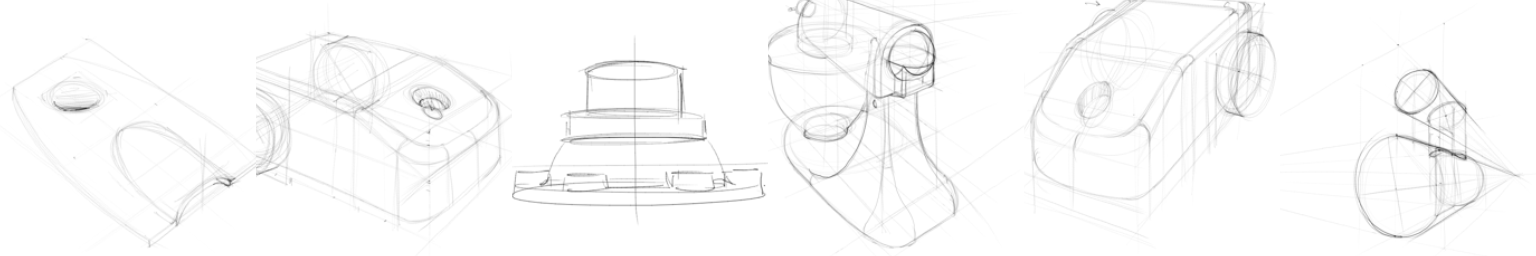

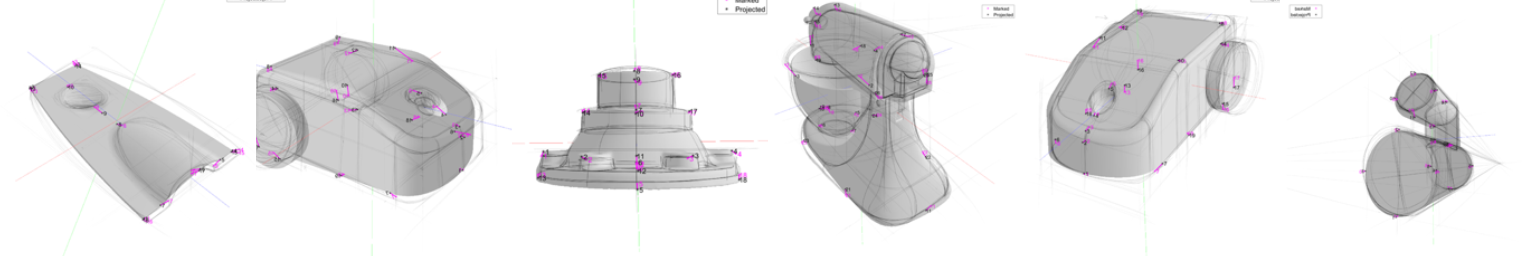

In [21]:
# Let's look at 6 random samples:

train_batch = minibatch(trainAB, 6, direction=0)
_, trainA, trainB = next(train_batch)
showX(trainA)
showX(trainB)

### Training:

*(keeps last few outputs in the log)*

In [22]:
number_of_epochs = 200    
batchSize = 64           ### batch size ~ how many images are loaded in the memory at the same time
                          # Note: you will probably need to lower this number on your own PCs...
                          # 128 was the max I got out of Colab

[199/200][2000] Loss_D: 0.582856 Loss_G: 0.957862 loss_L1: 0.023631 9784.183894872665


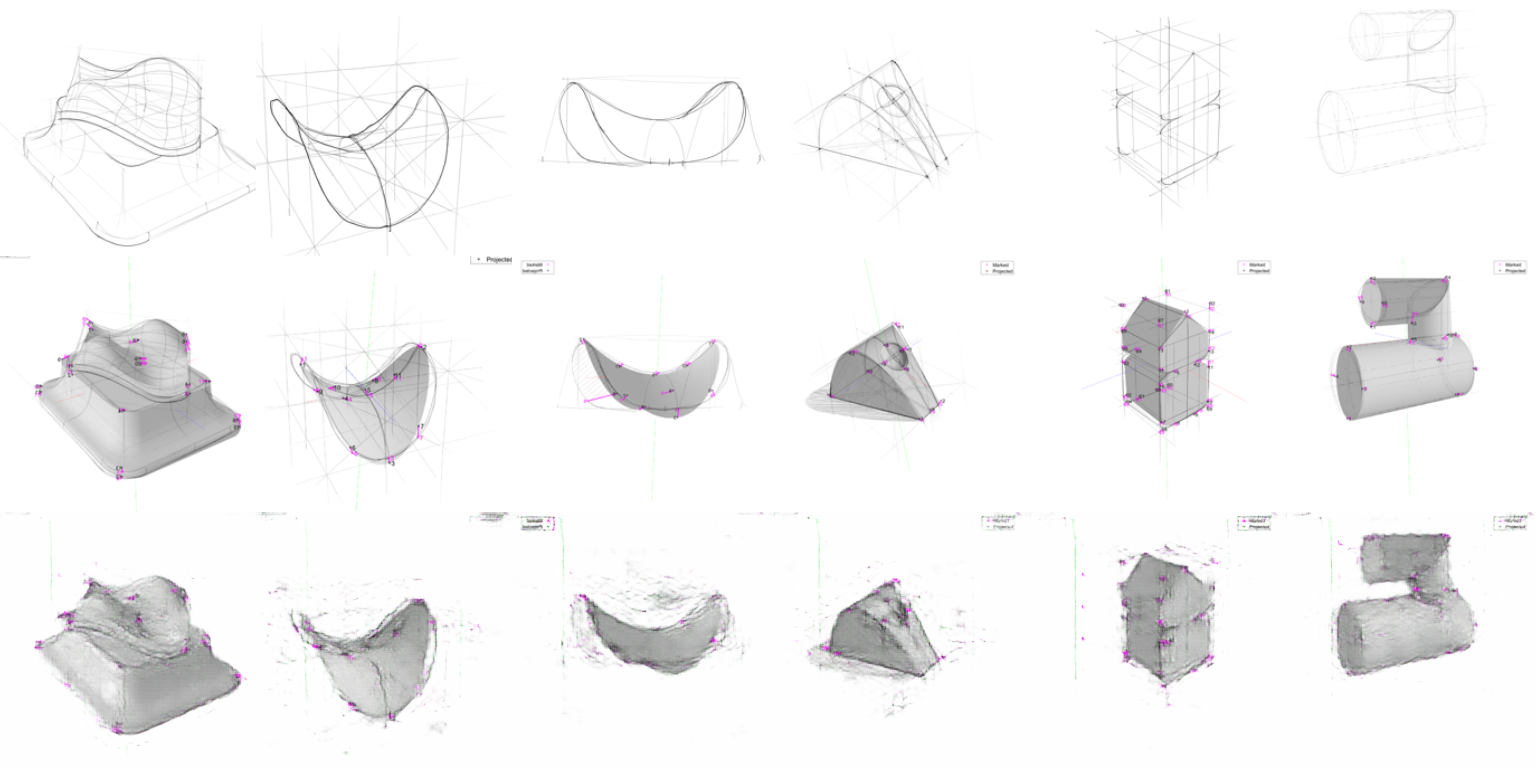

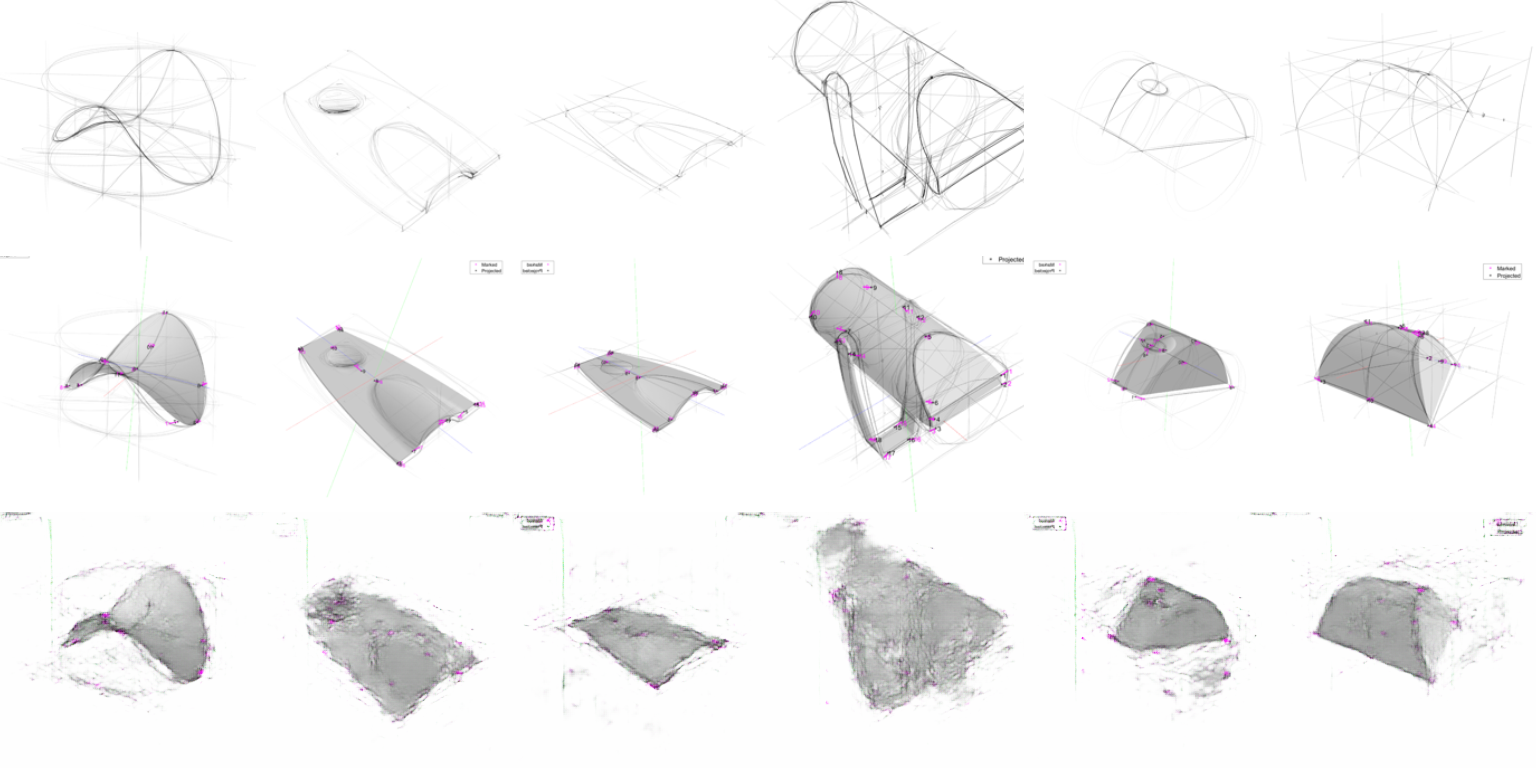

In [23]:
import time
from IPython.display import clear_output
t0 = time.time()
gen_iterations = 0
errL1 = epoch = errG = 0
errL1_sum = errG_sum = errD_sum = 0

display_iters = 5   ### How often should we visualize output
val_batch = minibatch(valAB, 6, direction)
train_batch = minibatch(trainAB, batchSize, direction)

def netG_gen(A):
    return np.concatenate([netG_generate([A[i:i+1]])[0] for i in range(A.shape[0])], axis=0)

while epoch < number_of_epochs: 
    epoch, trainA, trainB = next(train_batch)        
    errD,  = netD_train([trainA, trainB])
    errD_sum +=errD

    errG, errL1 = netG_train([trainA, trainB])
    errG_sum += errG
    errL1_sum += errL1
    gen_iterations+=1
    if gen_iterations%display_iters==0:
        if gen_iterations%(5*display_iters)==0:
            clear_output()
        print('[%d/%d][%d] Loss_D: %f Loss_G: %f loss_L1: %f'
        % (epoch, number_of_epochs, gen_iterations, errD_sum/display_iters, errG_sum/display_iters, errL1_sum/display_iters), time.time()-t0)
        _, valA, valB = train_batch.send(6) 
        fakeB = netG_gen(valA)
        showX(np.concatenate([valA, valB, fakeB], axis=0), 3)
        errL1_sum = errG_sum = errD_sum = 0
        _, valA, valB = next(val_batch)
        fakeB = netG_gen(valA)
        showX(np.concatenate([valA, valB, fakeB], axis=0), 3)
        

Inference:

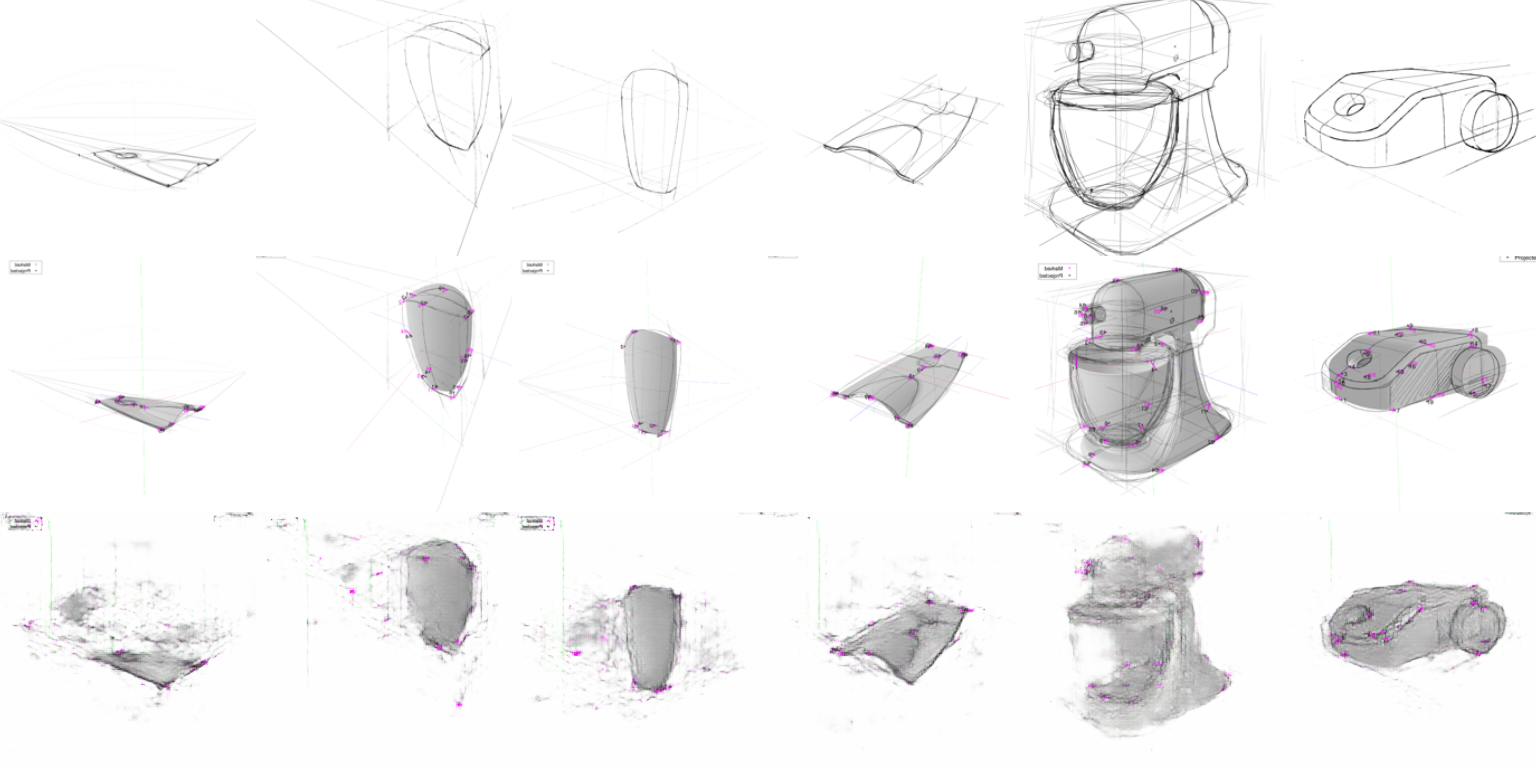

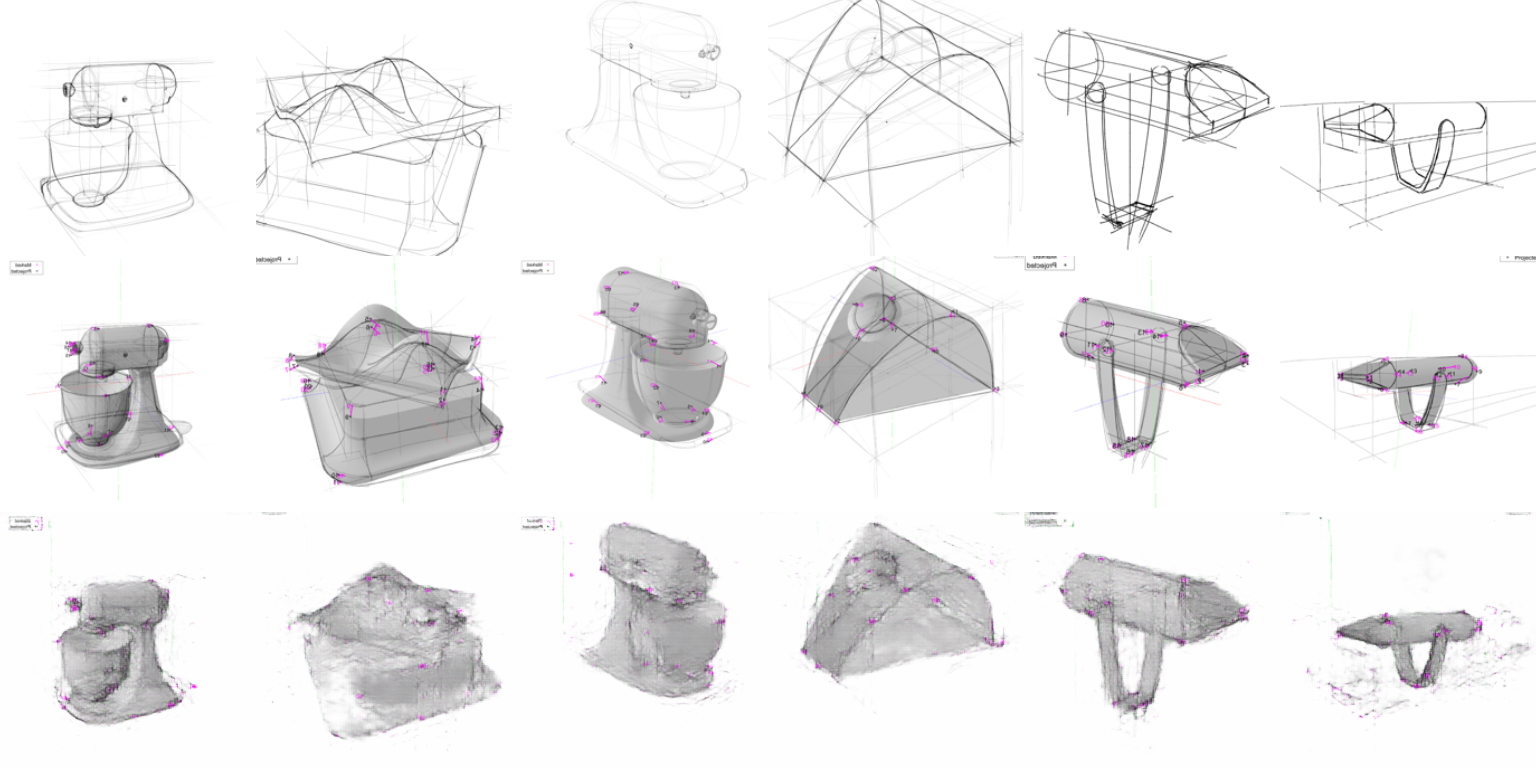

In [45]:
_, valA, valB = train_batch.send(6) 
fakeB = netG_gen(valA)
showX(np.concatenate([valA, valB, fakeB], axis=0), 3)
errL1_sum = errG_sum = errD_sum = 0
_, valA, valB = next(val_batch)
fakeB = netG_gen(valA)
showX(np.concatenate([valA, valB, fakeB], axis=0), 3)

### Save / Load model

In [ ]:
import tensorflow as tf
from tensorflow import keras
netG.save('netG_model')

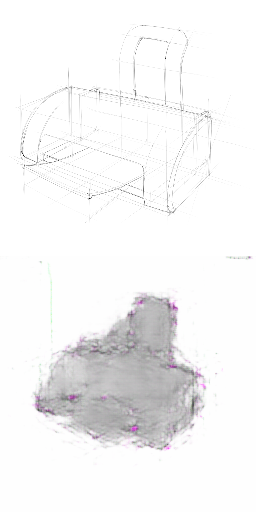

In [23]:
loaded_model = keras.models.load_model('netG_model', compile = False)
x = loaded_image
generatedImage = loaded_model.predict(x)
showX(np.concatenate([x, generatedImage], axis=0), 2)

## 03 Inference, using the pix2pix model

(1, 256, 256, 3)
(1, 256, 256, 3)


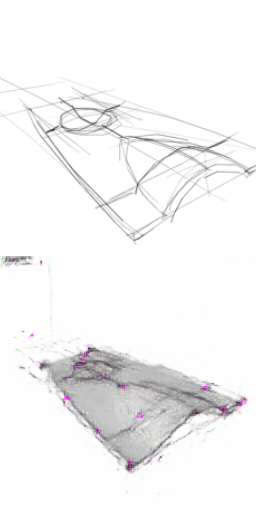

In [27]:
# One image:
_, inputImage, _ = train_batch.send(1)
print(inputImage.shape)

output = netG.predict(inputImage)
print(output.shape)
showX(np.concatenate([inputImage, output], axis=0), 2)

### generate from other images

We can also try the model with images that are not from our dataset ... we must remember to apply all the transforms in the same manner as we did with the data in the training dataset.

In [6]:
# Get a test image ...
# ... note that this is already in the edges representation ...
#!wget https://distill.pub/2017/aia/images/bread-cat-input.jpg

img = cv2.imread("view1_concept_opaque.png")
#img = (255-img) # invert it
res = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
res = res/255*2-1

print(res.shape)

loaded_image = np.reshape(res, (1, 256, 256, 3))

generatedImage = netG.predict(loaded_image)
showX(np.concatenate([loaded_image, generatedImage], axis=0), 2)

(256, 256, 3)


NameError: ignored

In [5]:
# If you need to convert the downloaded image to edges yourself:
import cv2
import numpy as np

imposter = "input.jpg"
img = cv2.imread(imposter,0)
edge = img2edge(img)
cv2.imwrite("edges.jpg", edge)

NameError: ignored

## even view it here

In [ ]:
!pip install -U kora

In [ ]:
# note: this one will upload the video into your drive home folder and then embed here in the notebook...

from kora.drive import upload_public
url = upload_public('output.mp4')
# then display it
from IPython.display import HTML
HTML(f"""<video src={url} width=500 controls/>""")